In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders

In [ ]:
# Import
import zipfile
import os
import splitfolders
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Instal gdown jika belum terinstal
!pip install gdown

# Mengunduh file zip dari Google Drive
!gdown --id 1d7rouTa0_Oe_uXTK-jlSVo8VdBgyyOIL -O dataset.zip

# Path ke file zip yang telah diunduh
zip_path = 'dataset.zip'

# Path ke direktori tujuan setelah diekstrak
extract_dir = '/content/dataset'

# Membuat direktori tujuan jika belum ada
os.makedirs(extract_dir, exist_ok=True)

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1d7rouTa0_Oe_uXTK-jlSVo8VdBgyyOIL
From (redirected): https://drive.google.com/uc?id=1d7rouTa0_Oe_uXTK-jlSVo8VdBgyyOIL&confirm=t&uuid=5fa5da8f-73f5-489f-8374-e89bd077478e
To: /content/dataset.zip
100% 394M/394M [00:13<00:00, 30.0MB/s]


In [ ]:
# Path ke direktori yang diekstrak
extract_dir = '/content/dataset/Indonesian Herb Leaf Dataset 3500'
output_dir = '/content/output'

# Membagi dataset menjadi 80% data pelatihan dan 20% data pengujian
splitfolders.ratio(extract_dir, output=output_dir, seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 3500 files [00:03, 1103.31 files/s]


In [ ]:
# Path ke direktori data pelatihan dan pengujian
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

# Inisialisasi ImageDataGenerator untuk data pelatihan dan pengujian
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Generator untuk data pengujian
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 2800 images belonging to 10 classes.
Found 700 images belonging to 10 classes.


In [ ]:
# Check the number of classes
print('Classes in training set:', train_generator.class_indices)
print('Classes in validation set:', val_generator.class_indices)

Classes in training set: {'Belimbing Wuluh': 0, 'Jambu Biji': 1, 'Jeruk Nipis': 2, 'Kemangi': 3, 'Lidah Buaya': 4, 'Nangka': 5, 'Pandan': 6, 'Pepaya': 7, 'Seledri': 8, 'Sirih': 9}
Classes in validation set: {'Belimbing Wuluh': 0, 'Jambu Biji': 1, 'Jeruk Nipis': 2, 'Kemangi': 3, 'Lidah Buaya': 4, 'Nangka': 5, 'Pandan': 6, 'Pepaya': 7, 'Seledri': 8, 'Sirih': 9}


In [ ]:
# Memuat model InceptionV3 yang telah dilatih pada ImageNet, tanpa lapisan atas (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Menambahkan lapisan akhir khusus untuk klasifikasi 10 kelas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Menambahkan dropout
predictions = Dense(10, activation='softmax')(x)

# Membuat model yang lengkap
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan lapisan dari base model agar tidak dilatih ulang
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=9
)

Epoch 1/9
87/87 [==============================] - 542s 6s/step - loss: 0.7736 - accuracy: 0.7565 - val_loss: 0.2368 - val_accuracy: 0.9286
Epoch 2/9
87/87 [==============================] - 458s 5s/step - loss: 0.2859 - accuracy: 0.8996 - val_loss: 0.1454 - val_accuracy: 0.9524
Epoch 3/9
87/87 [==============================] - 454s 5s/step - loss: 0.2105 - accuracy: 0.9296 - val_loss: 0.1101 - val_accuracy: 0.9732
Epoch 4/9
87/87 [==============================] - 455s 5s/step - loss: 0.1504 - accuracy: 0.9494 - val_loss: 0.1284 - val_accuracy: 0.9568
Epoch 5/9
87/87 [==============================] - 509s 6s/step - loss: 0.1124 - accuracy: 0.9632 - val_loss: 0.1133 - val_accuracy: 0.9628
Epoch 6/9
87/87 [==============================] - 516s 6s/step - loss: 0.1274 - accuracy: 0.9548 - val_loss: 0.0865 - val_accuracy: 0.9762
Epoch 7/9
87/87 [==============================] - 457s 5s/step - loss: 0.0804 - accuracy: 0.9725 - val_loss: 0.0884 - val_accuracy: 0.9792
Epoch 8/9
87/87 [===

In [ ]:
# Menampilkan summary dari model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 111, 111, 32)         96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_28

In [ ]:
# Fungsi untuk mengevaluasi apakah model overfitting, underfitting, atau good fit
def evaluate_model(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plotting the loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluating the model fit
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]

    if final_train_loss > final_val_loss and final_train_acc < final_val_acc:
        print("Kesimpulan: Model mengalami underfitting.")
    elif final_train_loss < final_val_loss and abs(final_train_loss - final_val_loss) > 0.1:
        print("Kesimpulan: Model mengalami overfitting.")
    else:
        print("Kesimpulan: Model memiliki good fit.")

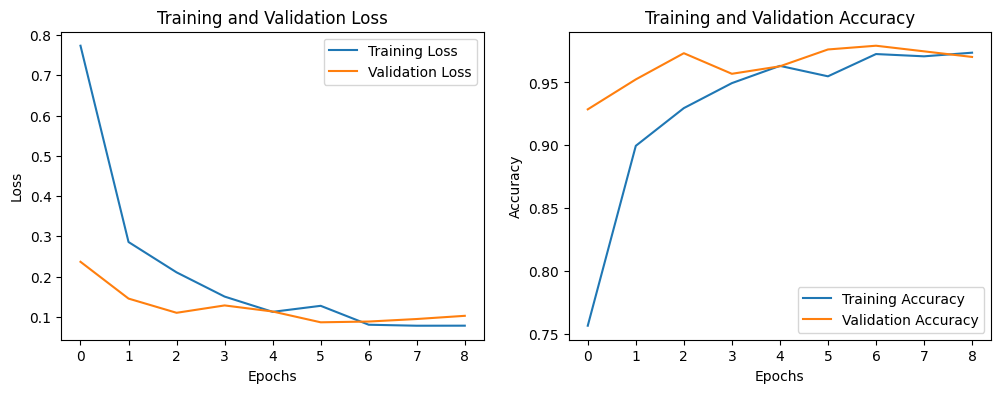

Kesimpulan: Model memiliki good fit.


In [ ]:
# Evaluasi model
evaluate_model(history)

1/1 [==============================] - 5s 5s/step


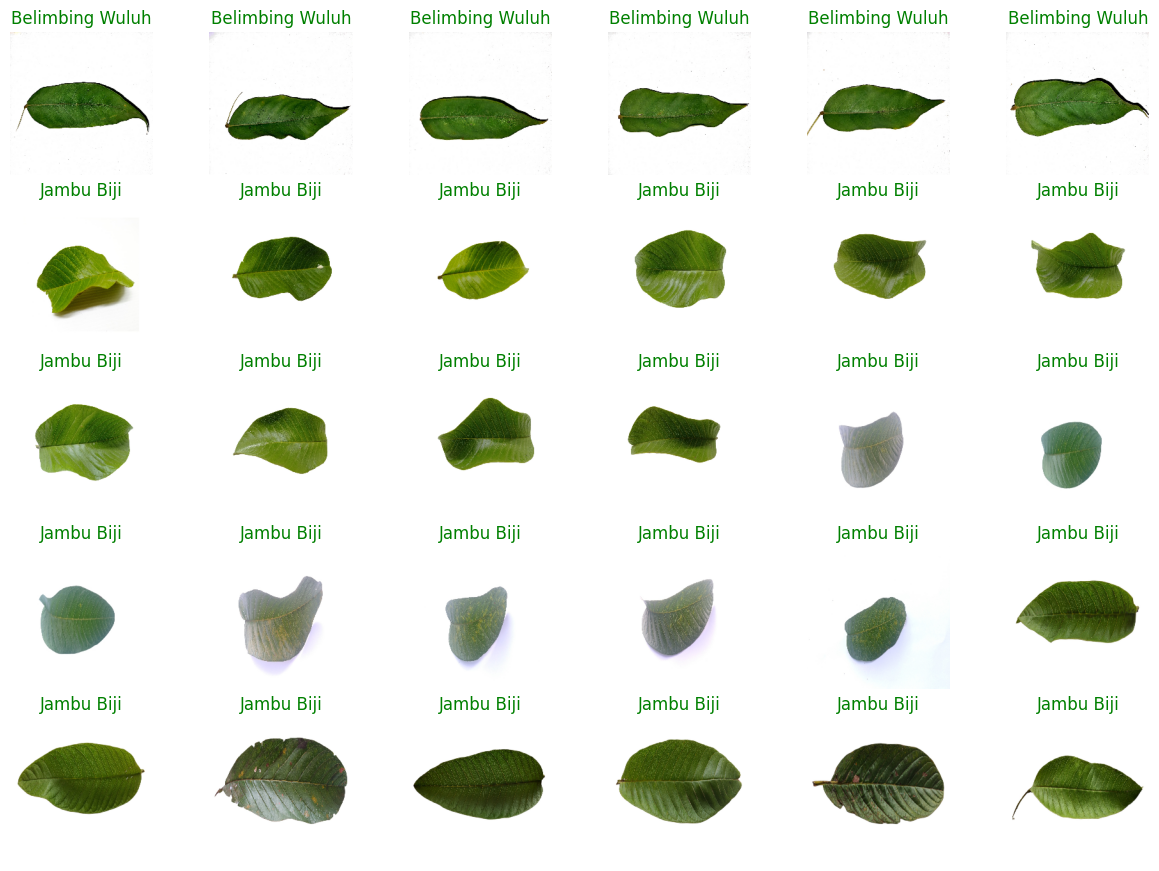

In [ ]:
# Mengambil gambar dan label dari generator validasi
img, labels = next(val_generator)

# Melakukan prediksi menggunakan model
predictions = model.predict(img)

# Mengambil kelas nama
class_names = list(val_generator.class_indices.keys())

# Menampilkan gambar-gambar dengan prediksi dan labelnya
plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])

    # Mengambil prediksi dan label
    pred = np.argmax(predictions[i])
    true_label = np.argmax(labels[i])  # Mengambil indeks kelas yang benar

    # Mengecek apakah prediksi benar atau salah
    if pred == true_label:
        plt.title(class_names[pred], color='green')
    else:
        plt.title(class_names[pred], color='red')

    plt.axis("off")

plt.show()

22/22 [==============================] - 112s 5s/step


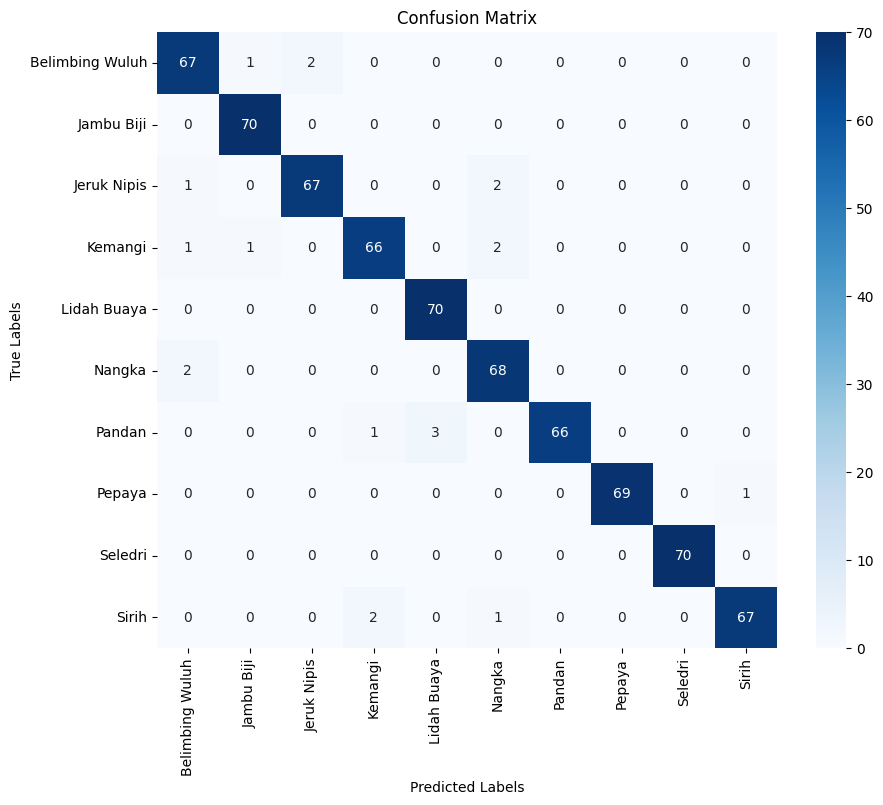

                 precision    recall  f1-score   support

Belimbing Wuluh       0.94      0.96      0.95        70
     Jambu Biji       0.97      1.00      0.99        70
    Jeruk Nipis       0.97      0.96      0.96        70
        Kemangi       0.96      0.94      0.95        70
    Lidah Buaya       0.96      1.00      0.98        70
         Nangka       0.93      0.97      0.95        70
         Pandan       1.00      0.94      0.97        70
         Pepaya       1.00      0.99      0.99        70
        Seledri       1.00      1.00      1.00        70
          Sirih       0.99      0.96      0.97        70

       accuracy                           0.97       700
      macro avg       0.97      0.97      0.97       700
   weighted avg       0.97      0.97      0.97       700



In [ ]:
# Get the true labels and the predicted labels
val_generator.reset()
Y_pred = model.predict(val_generator, val_generator.samples // val_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(val_generator.classes, y_pred)
cm_plot_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(val_generator.classes, y_pred, target_names=cm_plot_labels)
print(report)

In [ ]:
# Simpan model dalam format H5
model.save('ModelHerbPedia.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip uninstall tflite-support -y

In [ ]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
# Define the input and output tensors with their corresponding metadata
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [ ]:
# Add metadata
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Provide a representative dataset to calibrate the quantization
        yield [input_data]
converter.representative_dataset = representative_dataset_gen

In [ ]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Simpan model TFLite dalam file
with open('ModelHerbPedia.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Unduh file H5 dan TFLite
files.download('ModelHerbPedia.h5')
files.download('ModelHerbPedia.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>